<a href="https://colab.research.google.com/github/davidfague/Stylized-ReducedOrder-L5-Model/blob/main/Create_NR_Geometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quick Start
## The following code shows the main function that is used to reduce a complex cell.

complex_cell  # The model cell

synapses_list # A list of all synapse on this cell

netcon_list   # A list of all netcons for the synapses on the cell

import neuron_reduce

reduced_cell, synapses_list, netcons_list =  neuron_reduce.subtree_reductor(complex_cell, synapses_list, netcons_list)

# Detailed Example
## Example copied from github

In [1]:
!pip install neuron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install neuron_reduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!git clone https://github.com/orena1/neuron_reduce.git

fatal: destination path 'neuron_reduce' already exists and is not an empty directory.


In [4]:
# Go to example folder
%cd neuron_reduce 
%cd example
# compile the mod files
!nrnivmodl mod

/content/neuron_reduce
/content/neuron_reduce/example
/content/neuron_reduce/example
Mod files: "mod/mod/CaDynamics_E2.mod" "mod/mod/Ca_HVA.mod" "mod/mod/Ca_LVAst.mod" "mod/mod/epsp.mod" "mod/mod/Ih.mod" "mod/mod/Im.mod" "mod/mod/K_Pst.mod" "mod/mod/K_Tst.mod" "mod/mod/Nap_Et2.mod" "mod/mod/NaTa_t.mod" "mod/mod/NaTs2_t.mod" "mod/mod/SK_E2.mod" "mod/mod/SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


Define The Cell

In [5]:
#Run the code
from __future__ import division
from neuron import gui,h
import numpy as np
import neuron_reduce
import time
import matplotlib.pyplot as plt

#Create a L5_PC model
h.load_file('L5PCbiophys3.hoc')
h.load_file("import3d.hoc")
h.load_file('L5PCtemplate.hoc')
complex_cell = h.L5PCtemplate('cell1.asc')
h.celsius = 37
h.v_init = complex_cell.soma[0].e_pas

Add synapses to the cell

In [6]:
#Add synapses to the model
synapses_list, netstims_list, netcons_list, randoms_list = [], [], [] ,[]

all_segments = [i for j in map(list,list(complex_cell.apical)) for i in j] + [i for j in map(list,list(complex_cell.basal)) for i in j]
len_per_segment = np.array([seg.sec.L/seg.sec.nseg for seg in all_segments])
rnd = np.random.RandomState(10)
for i in range(10000):
    seg_for_synapse = rnd.choice(all_segments,   p=len_per_segment/sum(len_per_segment)) #choose a random segment with probability based on the length of segment
    synapses_list.append(h.Exp2Syn(seg_for_synapse))
    if rnd.uniform()<0.85: # 85% synapses are excitatory
        e_syn, tau1, tau2, spike_interval, syn_weight = 0, 0.3, 1.8,  1000/2.5, 0.0016
    else: #inhibitory case
        e_syn, tau1, tau2, spike_interval, syn_weight = -86, 1,   8,   1000/15.0, 0.0008
    #set synaptic varibales
    synapses_list[i].e, synapses_list[i].tau1, synapses_list[i].tau2 = e_syn, tau1, tau2
    #set netstim variables
    netstims_list.append(h.NetStim())
    netstims_list[i].interval, netstims_list[i].number, netstims_list[i].start, netstims_list[i].noise = spike_interval, 9e9, 100, 1
    #set random
    randoms_list.append(h.Random())
    randoms_list[i].Random123(i)
    randoms_list[i].negexp(1)
    netstims_list[i].noiseFromRandom(randoms_list[i])       
    #set netcon varibales 
    netcons_list.append(h.NetCon(netstims_list[i], synapses_list[i] ))
    netcons_list[i].delay, netcons_list[i].weight[0] = 0, syn_weight

In [7]:
print(seg_for_synapse)

L5PCtemplate[0].dend[82](0.0714286)


Simulate the full neuron for 1 seconds

In [8]:
soma_v = h.Vector()
soma_v.record(complex_cell.soma[0](0.5)._ref_v)

time_v = h.Vector()
time_v.record(h._ref_t)

h.tstop = 1000
st = time.time()
h.run()
print('complex cell simulation time {:.4f}'.format(time.time()-st))
complex_cell_v = list(soma_v)


complex cell simulation time 42.9041


Gather complex cell geometry

In [9]:
import pandas as pd
def generate_stylized_geometry(cell,savename):
  df = pd.DataFrame()
  ids=[]
  names=[]
  types=[]
  pids=[]
  axials=[]
  nbranchs=[]
  Ls=[]
  Rs=[]
  angs=[]

  id=0
  for sec in cell.all:
    name=sec.name()
    names.append(name)
    ids.append(names.index(name))
    _,sec_type_withinteger=name.split('.')
    sec_type,_=sec_type_withinteger.split('[')
    types.append(sec_type)
    pseg = sec.parentseg()
    if pseg == None:
      pids.append(None)
    else:
      psec=pseg.sec
      pids.append(names.index(psec.name()))
    axials.append('TRUE')
    nbranchs.append(1)
    Ls.append(sec.L)
    # print(dir(sec))
    Rs.append(sec.diam/2) # may need to compute single radius for each section
    angs.append(180)

  print(len(ids))
  print(len(names))
  print(len(types))
  print(len(pids))
  print(len(axials))
  print(len(nbranchs))
  print(len(Ls))
  print(len(Rs))
  print(angs)
  df["id"] = ids
  df["name"] = names
  df["pid"] = pids
  df["axial"] = axials
  df["type"] = types
  df["nbranch"] = nbranchs
  df["L"] = Ls
  df["R"] = Rs
  df["ang"] = angs
  df.to_csv(savename)

generate_stylized_geometry(cell=complex_cell,savename='geom_complex.csv')

196
196
196
196
196
196
196
196
[180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 18

In [10]:
%ls

cell1.asc  complex_geom.csv  geom_complex.csv  L5PCtemplate.hoc  x86_64/
Cell.hoc   example.py        L5PCbiophys3.hoc  mod/


apply Neuron_Reduce to simplify the cell and run the simulation again on the reduced cell

reduced cell simulation time 1.1384


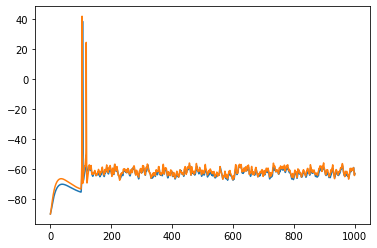

In [11]:
#apply Neuron_Reduce to simplify the cell
reduced_cell, synapses_list, netcons_list = neuron_reduce.subtree_reductor(complex_cell, synapses_list, netcons_list, reduction_frequency=0, total_segments_manual=-1)
for r in randoms_list:r.seq(1) #reset random


#Running the simulation again but now on the reduced cell
st = time.time()
h.run()
print('reduced cell simulation time {:.4f}'.format(time.time()-st))
reduced_celll_v = list(soma_v)

#plotting the results
plt.figure()

plt.plot(time_v, complex_cell_v, label='complex cell')
plt.plot(time_v, reduced_celll_v,  label='reduced cell')
plt.show()

In [12]:
dir(reduced_cell.hoc_model)

['__abs__',
 '__add__',
 '__bool__',
 '__call__',
 '__class__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__next__',
 '__pos__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 'all',
 'apic',
 'apical',
 'axon',
 'axonal',
 'basal',
 'baseattr',
 'biophys',
 'delete_axon',
 'dend',
 'geom_nseg',
 'hname',
 'hocobjptr',
 'init',
 'same',
 'soma',
 'somatic']

In [18]:
complex_df = pd.read_csv('geom_complex.csv') #need to begin reduced_df with soma from complex_cell
df = pd.DataFrame()
ids=[complex_df['id'][0]]
names=[complex_df['name'][0]]
types=[complex_df['type'][0]]
pids=[complex_df['pid'][0]]
axials=[complex_df['axial'][0]]
nbranchs=[complex_df['nbranch'][0]]
Ls=[complex_df['L'][0]]
Rs=[complex_df['R'][0]]
angs=[complex_df['ang'][0]]

for sec in reduced_cell.hoc_model.all:
  name=sec.name()
  print(name)
  names.append(name)
  ids.append(names.index(name))
  _,sec_type_withinteger=name.split('.')
  sec_type,_=sec_type_withinteger.split('[')
  types.append(sec_type)
  pseg = sec.parentseg()
  if pseg == None:
    pids.append(None)
  else:
    psec=pseg.sec
    px3d=psec.x3d
    pids.append(names.index(psec.name()))
  axials.append('TRUE')
  nbranchs.append(1)
  Ls.append(sec.L)
  # print(dir(sec))
  Rs.append(sec.diam/2) # may need to compute single radius for each section

  if sec.n3d() != 0:
    print(sec.n3d())
    first_x3d=sec.x3d(0)
    first_y3d=sec.y3d(0)
    first_z3d=sec.z3d(0)
    last_x3d=sec.x3d(sec.n3d()-1)
    last_y3d=sec.y3d(sec.n3d()-1)
    last_z3d=sec.z3d(sec.n3d()-1)

    pfirst_x3d=psec.x3d(0)
    pfirst_y3d=psec.y3d(0)
    pfirst_z3d=psec.z3d(0)
    plast_x3d=psec.x3d(psec.n3d()-1)
    plast_y3d=psec.y3d(psec.n3d()-1)
    plast_z3d=psec.z3d(psec.n3d()-1)
    print(first_x3d-plast_x3d)
    print(first_y3d-plast_y3d)
    print(first_z3d-plast_z3d)
  else:
    angs.append(None)

# print(len(ids))
# print(len(names))
# print(len(types))
# print(len(pids))
# print(len(axials))
# print(len(nbranchs))
# print(len(Ls))
# print(len(Rs))
# print(angs)
df["id"] = ids
df["name"] = names
df["L"] = pids
df["axial"] = axials
df["type"] = types
df["nbranch"] = nbranchs
df["L"] = Ls
df["R"] = Rs
df["ang"] = angs
df.to_csv('geom_reduced.csv')

['L', 'Ra', '__call__', '__class__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'allseg', 'arc3d', 'cell', 'children', 'connect', 'diam3d', 'disconnect', 'has_membrane', 'hname', 'hoc_internal_name', 'insert', 'is_pysec', 'n3d', 'name', 'nseg', 'orientation', 'parentseg', 'psection', 'pt3dadd', 'pt3dchange', 'pt3dclear', 'pt3dinsert', 'pt3dremove', 'pt3dstyle', 'push', 'rallbranch', 'same', 'spine3d', 'subtree', 'trueparentseg', 'uninsert', 'wholetree', 'x3d', 'y3d', 'z3d']
model[0].apic[0]
['L', 'Ra', '__call__', '__class__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__l

In [26]:
for sec in reduced_cell.hoc_model.all:
  print(sec.n3d())

0
0
0
0
0
0
0
0
0


In [14]:
dir(reduced_cell.hoc_model.soma)
# print(reduced_cell.hoc_model.soma.name())
# print(len(list(reduced_cell.hoc_model.apical)))
# print(len(list(reduced_cell.hoc_model.basal)))
# print(len(list(reduced_cell.hoc_model.somatic)))
# print(len(list(reduced_cell.hoc_model.all)))

['__abs__',
 '__add__',
 '__bool__',
 '__call__',
 '__class__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__next__',
 '__pos__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 'all',
 'apic',
 'apical',
 'axon',
 'axonal',
 'basal',
 'baseattr',
 'biophys',
 'delete_axon',
 'dend',
 'geom_nseg',
 'hname',
 'hocobjptr',
 'init',
 'same',
 'soma',
 'somatic']

In [15]:
print(len(list(complex_cell.all)))
print(len(list(complex_cell.somatic)))

3
1


In [16]:
generate_stylized_geometry(cell=reduced_cell.hoc_model,savename='geom_reduced.csv')

ValueError: ignored

#Show Complex and Reduced Cell

In [ ]:
# print(complex_cell.dend[1])

In [ ]:
# dir(complex_cell)

#Reducing a Stylized Cell

# Reducing a L5PC model with more biophysically realistic synaptic input.

# Citation
O. Amsalem, G. Eyal, N. Rogozinski, M. Gevaert, P. Kumbhar, F. Schürmann, I. Segev. An efficient analytical reduction of detailed nonlinear neuron models. Nat. Commun., 11 (2020), p. 288